#  C.N.N. Reconnaissances d'émotions 


Lien du tutoriel: https://www.freecodecamp.org/news/facial-emotion-recognition-develop-a-c-n-n-and-break-into-kaggle-top-10-f618c024faa7/

Dataset: fer2013 https://kaggle.com/deadskull7/fer2013

Si vous voulez travailler comme moi sur google colab voici un tutoriel

#### tutoriel Google Colab:  https://hackernoon.com/begin-your-deep-learning-project-for-free-free-gpu-processing-free-storage-free-easy-upload-b4dba18abebc


In [0]:
#Connect google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
#Import Libraries
import matplotlib.pyplot as plt

import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential #Initialise our neural network model as a sequential network
from keras.layers import Conv2D #Convolution operation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation#Applies activation function
from keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from keras.layers import Dense # Regular fully connected neural network
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


#### Apercu d'un exemple

(48, 48)


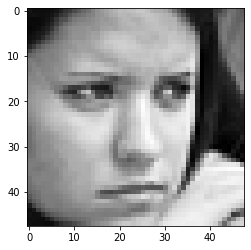

In [2]:
dataset_path="C:\\Users\Fatah\Downloads\IA Doc\Learn 3(need to update it from drive)\\fer2013.csv"
#dataset_path="/content/gdrive/My Drive/Google Colab/Emotions Recognizer/fer2013.csv"

with open(dataset_path, 'r') as file:
        for line_no, line in enumerate(file.readlines()):
            if 0< line_no <=35887:
                curr_class, line, set_type = line.split(',')  
                #Creating a list out of the string then converting it into a 2-Dimensional numpy array.
                image_data=np.asarray([int(x) for x in line.split()]).reshape(48,48)
            

#plot last image in the dataset 
print(image_data.shape)
plt.imshow(image_data,cmap='gray')   

### Prétraitements

Toutes les images de dataset ont une taille de 48x48. Étant donné que ces images sont en grises ( pas RGB), il n'y a qu'un seul canal. 
Nous allons extraire les données d'image et les réorganiser dans un array 48x48. Puis les convertir en entier et les diviser par 255 pour normaliser les données.

In [33]:
train_data=[]
test_data =[]
test_labels=[]
train_labels=[]
test_list=[]

with open(dataset_path, 'r') as file:
        for line_no, line in enumerate(file.readlines()):
            if 0< line_no <=35887:
                curr_class, line, set_type = line.split(',')  
                
                #Creating a list out of the string then converting it into a 2-Dimensional numpy array.
                image_data=np.asarray([int(x) for x in line.split()]).reshape(48,48)
                #normalize
                image_data=image_data.astype(np.uint8)/255.0
                 
                #verify if the image is used for training or test (or other)
                if(set_type.strip() == 'Training'):
                    train_data.append(image_data)
                    train_labels.append(curr_class)
                else:
                    test_data.append(image_data)
                    test_labels.append(curr_class)
print(type(train_data))                

<class 'list'>


Reshape de (48,48) en (48,48,1) et appliquer le onehot encoding pour les labels

In [34]:
#2D en 3D 
train_data= np.expand_dims(train_data,-1)
train_labels = to_categorical(train_labels, num_classes= 7)
test_data = np.expand_dims(test_data, -1)
test_labels = to_categorical(test_labels, num_classes=7)

In [35]:
print(type(train_data))
print("Number of images in Training set:", len(train_data))
print("Number of images in Test set:", len(test_data))

<class 'numpy.ndarray'>
Number of images in Training set: 28709
Number of images in Test set: 7178


Je vérifie juste si les 5 premieres images après les traitements ont toujours le bon label

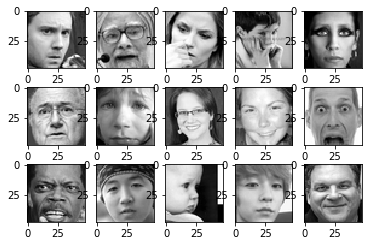

In [59]:
#plot 

f, axarr = plt.subplots(3,5)

cpt=0
for i in range(3):
    for j in range(5):
        
        test_image=np.copy(train_data[cpt])
  
        #because it's 28x28x1, last dimension is not RGB,it's greyscale
        #so we can remove it

        test_image=test_image[:,:,0]
        #print(test_image.shape)
        axarr[i,j].imshow(test_image,cmap='gray')
        cpt+=1


In [60]:
# Afficher les 15 premiers labels du train
np.argmax(train_labels[:15],axis=1)

array([0, 0, 2, 4, 6, 2, 4, 3, 3, 2, 0, 6, 6, 6, 3], dtype=int64)

Description des 7 emotions: 
 - 0 'Angry'  
 - 1 'Disgust'   
 - 2 'Fear'    
 - 3 'Happy'    
 - 4 'Sad'    
 - 5 'Surprise'   
 - 6 'Neutral'

Les prétraitements sont correctes

## Modèle du tutoriel

In [0]:
# HYPERPARAMATERS
epochs = 100
batch_size = 64
learning_rate = 0.001


model = Sequential()
    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXAAAAD7CAYAAABzGc+QAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nO2dW4xc1ZWGv+1b2m2Mr/Elbl8A2xAcYuOYm5KQACFiIAqJlBklRBGKIvGSkRJNpARmXuZhRpq8JJmH0UhIjMRIkZIZGxFESMiIJMAgxcTYZixjro5t2hi3DRiwjXG7e89D1V971+qq6m539ak67fVL1ulz6py99zl/uf511lp77RBjxOFwOBzlw7ROD8DhcDgc5wf/AXc4HI6Swn/AHQ6Ho6TwH3CHw+EoKfwH3OFwOEoK/wF3OByOkmJCP+AhhNtCCC+FEF4NIdzbrkE5OgvnderCuZ1aCOebBx5CmA68DNwK9AN/Br4RY3yhfcNzFA3nderCuZ16mIgFfi3waoxxf4zxLPAL4M72DMvRQTivUxfO7RTDjAlcuwJ4PdvvB65rdcHChQvjypUrOXfuHACnTp0CYNq0aXXbM2fOADBz5kwApk+fDkAIIQ18RmXob731FgDvvfdeXV8f+chHAJg7d25dW2pDbdq+tdV5dtvojaXZW0w+3kbna/vhhx8CMDQ01PB8Pa9WfasNPTtdozGo7eHhYf1rPDjntYYpxiuMk1vntf78TvFa3T8eY/yobW8iP+CN7nbEiEMI9wD3AKxYsYLf/OY3PPvsswD09/cD8LGPfQxI5GrwixcvVhsAzJkzp9buQw89BMAjjzwCwMKFCwG48sorAfjMZz4DwNq1a4H0BbFtLViwAICLLroIgJ6enrrz9MXTF2UsaPZFEBkiS9t3330XSM/jxIkTQHoOp0+fBtLzyaEv9qFDhwB4/fXK/8/9+/cD8MEHH9Td15kzZxgYGGg5/AbHnFdKzyuMgVvnNaFbeAU4fPjwwUZjnIgLpR9Yme33AW/Yk2KM98cYt8QYtyxatGgC3TkKgvM6dTEqt85ruTARC/zPwLoQwiXAYeDrwF2tLhgaGuLdd9+tKVNvby8Ag4ODQHq9+OhHK28KUjyp8bZt22ptbd26FUgKdfnllwOwefNmICn7rFmz6sYgZZOi29c+jUFKbl/Jcuhc+3pnz7WvWmpb182bN6/ufoXjx48D6dVVSv/+++/XzpEloz40pvnz5wPp+ega+zwawHmdmrzCOLl1Xqlruxt5Pe8f8BjjuRDC3wKPA9OB/4gx7j3f9hzdAed16sK5nXqYiAVOjPEx4LGxnj80NMTJkydr6qOAxcmTJ4Gk8GfPnq0Mrqp8zzzzDACPPZa6UhBEr3lS8E2bNtW1JUhtZ8+eDSQfmvqQEmZBA2BkUCH3relcnaN9C/Vhr5Oia0zyIaovPQcFPI4ePQrAO++8U2tLii1LRcqtPvQctD84ONg0iCM4r1OTVxgft85r/XWd4rUVfCamw+FwlBQTssDHi+HhYU6ePFlTGet7kn9LCvjqq68C8PDDDwPwxhsp3rJs2TIArrrqKgBuuOEGAC6++OK6NtWWFFzq2SzlySq69q3/LP9biivYFKfRjqtvjU0+Ram1LB7dm+4FUjRb1+h+dY2UXmOcOXPmuCL0Y4Hz6ryC8zpZvLaCW+AOh8NRUhRugX/wwQc1RZdvSBFmqY+OP/roo0BSdn0OsH79egC2bNkCwMqVlewoRW2tv8pOEFCkXOcpoiyf02hJ+tA8f3Q0RRfsZAX50ARFrKXO8qnlqqz71Wd6tvKtNVLyZuM+Xzivzis4r5PFayu4Be5wOBwlRaEWeAiBadOm1VRRaip1leo89dRTALUZYFK8fGLBZZddBsC6deuA5EuyU3KleNaPJ3W1M7e0lbpan1qzyHX+mW3LtiHofnVcY7PPRzmi1grJ+7DXyPpRTqr6GBoaGlO2wnjgvDqv4LxOFq+t4Ba4w+FwlBSFWuCC5vsrOiuf2vPPPw8kX5r1MSlyC7Bhw4a6Y2pLfihFgKWaVvmkcFZ97QwvWwchh809tZFxW6DG5qHaIjnWIpB/T1aHalC89tprtTHYWXG2OI6sAWUE9Pb2tt1XKjivzmsO57U9vLaCW+AOh8NRUhRqgQ8NDXHq1Kmaakqp5PdR/uixY8eAkcon/xnAmjVrgKTY8retWLECGFlDwM4W07621q9nlVwq28jPaHNR7UwuwdZesEpu/V52K6tFKp1Dyq5nqYppeg6K+qteQzvhvDqv4Lx2gle3wB0Oh6Ok8B9wh8PhKCkKD2LGGGuvZNoq/WjXrl3AyHQeBT6uueaaWjt6PdErlC0go1cppScpWGKDHXZarX3lUnqPXt0aBYpsOpFgp//az+2EADs5wRayUTsKjkAK/ug1Vm0p+KFXM2HVqlVjKfw/bjivI69zXp1XmDivUB8IzeEWuMPhcJQUHUkjtIr929/+FkjpSgoq6HNNv82DImpDyi71k6K/+eabQFI6TSRQGUtd12wigNS12cSBHLaovA2ONFvuyQZDbFDEplJpf+nSpbW+ly9fDiSF1n1I6TU1WcXle3p6Rp0ccL5wXp1XcF7bzWsruAXucDgcJUWhFniMkcHBwZqfa9++fUBKZtdx7Uu5br31VqA+qV3pN7aEo1RRBeRffvllAPburSw8snPnTgA++9nPAim9SaqpdpTOY1egzhdqtYn+Vu3zKbT5eTaNyfra7CQFbeWjk0pDSsOSUssPqmel47KWjh07NmqR+PHCeXVewXmdLF5bwS1wh8PhKCkKtcCnTZvG7Nmza4q2f/9+IC0SKgWX6lx99dUAXHHFFUC98qmE5Z49e4Ck8Cpbefr0aSApvtpUnyp5edttt9Vdp7HZaLcUPrdyrKLb0pi2+LydbKC2bMEdO3FAsMoOaUKEIv8HDx4E4MiRI0CyWKTsZ86cafuUa+fVeQXndbJ4bQW3wB0Oh6OkKNwC7+3trfm5pGi2DKOOf+ITnwBSBDpXdKma1PDw4cN118rXpGulcCqcLh+bFE5LPF166aV1Y5KfzxbAgeQTk1raLAAbtZZfS9aGjXpb31yz8pW6HtKUYllF2pdPUVNxFf0+fvx425fecl6dV3BeJ4vXVnAL3OFwOEqKQi3wc+fOMTAwMGLZICmiVbpLLrkESEqfR4ml1AcOHADg17/+NZBmMmkG06ZNmwBYvXo1kGaR/eUvfwFSFFizyt5++20gzZ6Swi9YsKBubJAUWvdjfWqyLqxvUoqt+7bn27KXalf95T41uxSV9bvJklE0ftWqVXWLzbYDzmsFzqvzmrfbLl4BXnzxRRrBLXCHw+EoKQpf1PjMmTMjSj1KueQHkvpoNpYitrmaSv1uvPFGIBVAlzJv3boVSEqnyLjKNKotzQRT34p6yzclBbQ1GSApuawA9aVrdR9SWe3b8pV2uShbWN5GovNot86xtSbUhmZ4vfLKK7X9VstMnQ+cV+cVnNfJ4rUV3AJ3OByOkqLwWighhBFLEdl6BvKhyadm6yBAqiGgc+68804g+eWk0E8//TSQZnRdf/31QFriSVFrtSf11MyoxYsX140/V1f1pYi6xm9rK9gqZ2pbubB2EVhZBKrIJkvAFrXP+7BRbbVprYldu3bVfHPthPPqvDqvk8NrK7gF7nA4HCVF4bVQhoaGRuRjClJ2O1vJVgXLIQWT/+1Tn/oUkBZcveuuu4CkgkuWLAGST04+NEWvNSbNiNL5Uuvcz6i+9ZmNjCvCrnoNOk8WitRW+8qFXbZsGZByQTXjTdZH/hw0Hn1mfWq22pmdsdYOOK/OKzivneDVLXCHw+EoKQq3wD/88MOaoitfUlFaqax8avI96fw8r1Qqb6O5X/jCF4DkU3rppZeAlCcqlVQfmzdvBpKvTGq5du1aIPmqNCNMKp6PR8qt+g2q5SufpNRV5+t+lava19cHJFVWn7on+d7Uvq6DkbmpgvrW57k1MVp9hfHCeXVewXmdLF7z+7FwC9zhcDhKilEt8BDCSuA/gWXAMHB/jPFfQwgLgV8Ca4ADwN/EGN9p1VaMkbNnz45QQim2FF2KZ2c85fmUdsUNqZ+U+ytf+QoA/f39QFJDKb2UWZaB2pbSy6emMUjx8zHomCwTKbMUWFFvqaqi1Mpx1Zh1vXxq8oNJlZWv2mjdPKm/nqGu1b7Nh501axYhBOfVeXVeS8JrK4zFAj8H/CDG+HHgeuC7IYQrgXuBJ2KM64AnqvuO8sB5nZpwXi8gjGqBxxiPAEeqf78fQtgHrADuBD5fPe1B4I/Aj1q1NW3aNObMmVOrbqZ18KQyUkApuNSp0UojeX2B6tjqtnZmliLD1ndmZ1XJX2VX+JAlkFcw0zVat0+zxuSvUv0GWQWqaaz7VI6rKo69/vrrQIqwKxquWWuK3OerjNgota3joKi3rYXsvDqvOK9AOXhthnH5wEMIa4Crge3A0uqXRV+aJeNpy9E9cF6nJpzXqY8xZ6GEEC4CtgHfjzG+N9bVP0II9wD3QMX/MzAwUFuRWUonH5SdXaXjUq18bTmpvJTdVgKT2sqfZWeH2RxVKZ6tb6CtjVTn45HCqu8vfvGLQMpJ3b17N5BWJXnyyScBeO655wC4/PLLgWQtKBKvHFmNTbPVcr+Yxit/m41u6znl6/aZ2gzOK85rdp3z2mW8tsKYLPAQwkwqX4afxxgfqh4+GkJYXv18OTDQ6NoY4/0xxi0xxi35q4Sj83Bepyac1wsHY8lCCcADwL4Y40+yjx4B7gb+pbr91WhtnTt3jhMnTtRUxa4sLXXWzCgpu1SpUU6njYBbH5k+t0ouC0BWhFU6qag+b5SHqfFIYTV+O7tK0WzVOlZtX/nWZLkoAm/zaG+55Za6MefV0fSfTM/KWlqyhnTfQ0NDDA8PO6/Oq/NaEl5bYSwulE8D3wL2hBB2V4/9PZUvwn+FEL4DHAL+egxtOboHzuvUhPN6AWEsWSj/CzRzoN0y3g5jjDU/l3xMgl3BQoootcoj2XY9Ohu9tcotZZei2Siv1NOui9cop7XZGOS3E6S8akO5rcoFlSWg66+55hogRcd1nmpMqOaCcl9zyOdnx2l9gyEEYozOq/M6Jjivnee1FXwmpsPhcJQUhdcDHxoaGqGSUnapqWY4Senke8oj0c3WrbMqapVckWGpolTTzuBS+41yWgW7Aor6tit5aAVt1UJWVF/+Llk4Um7lwGpMGrtd9RqSFWRrNAt2Zldvb2/ba2ZojM6r8wrOa7t5bQW3wB0Oh6Ok8B9wh8PhKCkKdaEoLUmpPrbAul5BNDW10fWCnZJqE/r1+qLXGaX86HVJBdNtuo4NouiVTK88jV7RbMAhn8CQX7N+/fq6rV1yyb5O2cVkm712QXoe+fJNeRsaw2gTA84Hzqvz2ux6wXmtR7t4dQvc4XA4SorCF3QYHByslZB86623gKSECg6oiLtUyJaUhJElG+2UXF0jFVSfus4W05GiSy1tMEGKmQdCdI76ttNg7eKmdvFU3Y8tw2mDLTaZPw+KqG0FlhRA0v3b5zA4ONgwxWoicF6dV40h/9x5re83b3s8vLaCW+AOh8NRUhRqgc+YMYNFixbVEtxVvlEJ9SqwLvWV30upQ3nivVTUKpbUzyq0zpMVobble5MKq10ppC3SLsXM/7ZLSdk+rZUhNEutaubns0XgIU0Z1nRfWR7NfGdnzpxpu6XmvDqv4LxOFq+t4Ba4w+FwlBSFWuA9PT2sX7++pljf/va3gZQ4r3KOdsqrkEeyVVDGFoq3qirVlfKpEM/27duBZCWsW7eurj0baZZq5/4ujccuMSUFt74xwfrOrFXSzM+n63TvQK3YvorP20h4o4Lx7bbUnFfqznNeK3Be28NrK7gF7nA4HCVF4T7wxYsXc+ONNwLJhyZIRW1heFvAJj8mBbMKrmWPVOpSEXMp2sGDB4G04OiRI0fq+rQLn1p1zc/RuOV3swuUWh+ZlNn63qyyaysrRP1oKSeAnTt3AnD48OG6PnS/ufpPFpxX5xWc107w6ha4w+FwlBSh3X6zVti4cWP83e9+Vyv+YpXPFmW3ytZoRpNVZPnOpOzK3Tx69CiQfGNSvIcffrhuX2ORj0oFa6699logLZsEqcCOFFdt29xVoVnk3T4HbRVRV/sqQSkVB3jhhReAZDVI2ffs2VPXVm41VP2lY1tjawxwXp3XfN95bS+v1bE8F2PcgoFb4A6Hw1FSFOoDnzlzJkuXLh2xrJL2FQ3OFwGF5INSaUlIaqdrpcg6R23v2LEDSLmp2qoE5oIFC4DkY9u8eTMAGzZsAFIe6qJFi4CU85qP1/rIZJFYhbbRaTvbSufpet2jlFy+tHy5KOXoqi2r5LbE5YwZM9qereC8Oq85nNf28pqfb+EWuMPhcJQUhS/oEGMcdYaTjfZK8XIlk89MeaGrVq0CUhF2qaIqpckvZf1a1113HZCi1xs3bgRSXQS1L4shtzbkx5IPTQpsFd5uNbtK+xqTIura6h4HBgbqrpMVko9HvjVF822VNmH27Nm1Z9FOOK/Oq/M6ObzmY7RwC9zhcDhKisIt8FaLdNrcTSmdzTOFNANLyiQFlw9Jn6tSmvqVKkp9ZSXIxzZ37ty6MTWbOZa3qT5t/qhVcG01ZntcY9J18g9aH2NeY0I+v71799a1ZZ+PMG/evFo/7YTz6rw6r5PDa962hVvgDofDUVIUboE3go3+2hlOUjhFZPNzbe6pzpGq2gVWdZ58S4pSy1pQHqn6lMrKYsjHYP1zQjNF11jUlvZlsdjqZTY/ddu2bUD9QqeqEKe8Wo3P1iyWws+bN49jx45RBJxX59Ve47yOn1eon82Zwy1wh8PhKCk6aoGPlm9p6wTkampzODXDS+poo7rW7yU/lY5v3boVSAp/0003AUlVpfi5j0rH7H1IwTU2nSfrQEqura7T2DQbTTPHnnzySQB2795NM+g+9KzUlvqWovf09IyoGtduOK/OKziv7eK1FdwCdzgcjpKiIxa4VUBbBUyKLpWy6gtJse2KFtZvZSumKe9Sqikfmlb0kLKr/vDnPvc5ADZt2lR3HSTltlXL7Mws9a2tPrcKrvvUcZ2vsdjz87YUjddnsn6UT6vnNXfu3ElZwRycV+fVec3H0i5eW8EtcIfD4SgpCrfAh4eHRyi50GxlD6l1npNqV8a26q/orbUWNANMaqnPP/nJTwJJPR9//HEA/vSnPwGputnNN99cG8PKlSvr+rbr10lt7erXikpbC0b7urfnn38egDfffLPuXvPnphxT+d+k5DpX0W4p/Zw5cybFV+q8Oq+C89peXlvBLXCHw+EoKQq1wGOMdSs0W5+drXKmrc0hhaR6Nu/TqqdVdF0nZVMfX/3qVwFYv349APv37wfSjCnlYT799NO1MVx11VUArF69Gkiqaesgqw99bpXc1lWWtSFrQpA/LFd0Rat1P3qmWsVbUXlZEZNhqTmvzmu+dV4raBevreAWuMPhcJQUY7bAQwjTgR3A4Rjjl0IIlwC/ABYCO4FvxRjPtmpDkArZmVxWhe2qzzlszqadDSb/Vh4BhqR4Ul3VVlAf2pdP6o477qhrP6/voLoGiqTrvmw9BrXVbF1AW1Nh165dQLIidL1WRsktG41b0XmNRT5FKbsUvbe3t85Sc16d19HgvHaW11YYjwX+PWBftv9j4KcxxnXAO8B3xtGWo3vgvE5NOK8XAMZkgYcQ+oA7gH8G/i5UpOlm4K7qKQ8C/wj8+yjt1KmdVTi74oWN9ubQMfmZpFTK8VRNXkWEpcTW3yWfk/WH6XzlmzZSa6mlFFlWhK2LrLFapbczwQ4dOgSkVTpshF6rjDSq8qbnoLFoDLpGVkE+Y895dV5pAee1O3hthbFa4D8DfgjoXWARcCLGqKfbD6wYY1uO7oHzOjXhvF4gGPUHPITwJWAgxvhcfrjBqQ0X5Ash3BNC2BFC2FFUtTTH6HBepyac1wsLY3GhfBr4cgjhdqAHuJiKws8PIcyoqnof8Eaji2OM9wP3A2zZsiWGEEYEOZotWaQARqNXs2bF2ZUCtGTJEmDkK4jOs2lKakeF4vv7+4GUnmSLvzeCAioary1IY8tW6j9Is9dHvZLpdVHt5elceqXUsk0q/K4puSr2o9fDWbNm6Z6dV5xXC+e1+3hthVEt8BjjfTHGvhjjGuDrwO9jjN8E/gB8rXra3cCvRmvL0T1wXqcmnNcLCxOZyPMj4BchhH8CdgEPjOWiGOOIwIMNHtgi51aFbXv5VqqprbUO7NaqrBTysssuA1JQRClCeWDDJvTb5ZF0H7IalDL0xhsV40fqa9OzNBYFOhQUsYuxAqxdu7auDVkJhw8frrsPIbPUmsF5dV5rcF47z2srjOsHPMb4R+CP1b/3A9eO53pHd8J5nZpwXqc+Cp1KPzw8zNmzZ2uKZH1PtgylVfTcF2cnDVi1l5Ug35LUVX3lyfWQlF1+MavGjQr6WB+gfGdSXh2Xr0yFatSmCtrYojrqW9No7TRi+c8gFftRSpNgS1xeccUVQCWVqt1lR51X5zXfOq/t5bUVfCq9w+FwlBSFF7MaHBwcUVrSRmutOjeaoisFlhrKP2eXQ5KySw21LzW2fkO7gKmWfpJK24kF+fjVx4kTJ4DkO1NR+oULFwJJhdW2XU7KLvSq57F48WIgWQKQFDovOgSpbOXbb78N1JfvHMVXOm44r85rDue1vby2glvgDofDUVJ0ZEk1mydpczwFG3HO1VTKLEW3Wym7VVlFqRVRVvRX6qp8VCm49fPJRwXJapDfTuqprRRauao2x1NbW/hdFozuV2PS9OO+vr7aGKTkdkFZuwyWxjh79uxJW/zWeXVe87E5r+3htRXcAnc4HI6SolALXMVxpLLWYrA5odb/lfuN9Jn1odlcVSm2XTT1qaeeAuDFF18EkopKdVX8XWqsdjQLC5KvTNaBVF++s+XLlwOprKTuW+fbYjmyFnS/KjyvvNJGBW4UMZc1pHPtwqvqe/78+W3PVnBenVdwXieL11ZwC9zhcDhKisIt8BkzZowo5m7LUlpltyqd/21VX/sHDhwA4JlnngFgw4YNQMq/lG9NiqdZVFJR9allkjSzKx+DXXhUailFt/Ud5O/Tfek6WQny69mFT3WdrI28voOi7+qjWbRe1sPp06dH5NROFM6r85pvndf28toKboE7HA5HSREaLX80aZ2FcAw4BRwvrNPzw2Km9hhXxxg/2q6BOK9thfM6fkx1XqEJt4X+gAOEEHbEGLcU2uk44WMcP7ptPI3gYxw/um08jXAhj9FdKA6Hw1FS+A+4w+FwlBSd+AG/vwN9jhc+xvGj28bTCD7G8aPbxtMIF+wYC/eBOxwOh6M9cBeKw+FwlBT+A+5wOBwlRWE/4CGE20IIL4UQXg0h3FtUv60QQlgZQvhDCGFfCGFvCOF71eMLQwj/E0J4pbpdMFpbBYx1eghhVwjh0er+JSGE7dUx/jKE0Lpw8OSOrau4dV7bNrau4hXKw21RvBbyAx5CmA78G/BXwJXAN0IIVxbR9yg4B/wgxvhx4Hrgu9Vx3Qs8EWNcBzxR3e80vgfsy/Z/DPy0OsZ3gO90YlBdyq3zOkF0Ka9QHm6L4TXGOOn/gBuAx7P9+4D7iuh7nOP8FXAr8BKwvHpsOfBSh8fVR+VLeTPwKBCozOqa0ej5Fjy2rufWeZ2avHYrt0XyWpQLZQXwerbfXz3WNQghrAGuBrYDS2OMRwCq2yWdGxkAPwN+CKha0SLgRIxRFfM7+Ty7mlvn9bzR1bxCV3NbGK9F/YA3Wqyva/IXQwgXAduA78cY3+v0eHKEEL4EDMQYn8sPNzi1U8+zm8ZSB+d1QuimsYxAt3JbNK9FlZPtB1Zm+33AGwX13RIhhJlUvgg/jzE+VD18NISwPMZ4JISwHBho3sKk49PAl0MItwM9wMVUFH5+CGFGVdU7+Ty7klvndcLoSl6h67ktlNeiLPA/A+uqkdhZwNeBRwrquylCpQjvA8C+GONPso8eAe6u/n03FT9bRxBjvC/G2BdjXEPluf0+xvhN4A/A16qndXKMXcet89oWdB2v0P3cFs5rgY7924GXgdeAf+hUgMGM6TNUXmX+D9hd/Xc7FZ/VE8Ar1e3CTo+1Ot7PA49W/74UeBZ4Ffhv4CMdHFdXceu8Tk1ey8ZtEbz6VHqHw+EoKXwmpsPhcJQUE/oB78aZWo6Jw3mdunBupxbO24VSnan1MpUk+n4qQY9vxBhfaN/wHEXDeZ26cG6nHiaSRngt8GqMcT9ACOEXwJ1A0y/DwoUL48qVK2srMZ86dQqAadOm1W21qrNWZp4+fTrVPtLAZ1SG/tZbbwHw3nv1qaBagVqrV6sttaE2bd/a6jy7bSR4zUQwhEbpn+l8bbWidr56dQ49r1Z9qw09O7vatdoeHh7Wv8aDc15rmGK8wji5dV7rz+8Ur9X947HBmpgT+QFvNFPrOntSCOEe4B6AFStW8Pjjj3P8eGVtz+3btwOJvDlz5gDw6quvArB06VIALrroIgBmz55da3fhwoUAPPjggwA88cQT6g+ASy+9FICbbrqpri0RPn/+/Lo+tVUfs2ZVas3oi6etHiikh5495Lpz9aUTdJ5IPHv2LACvvPIKkL7UGqPOP3bsWF1/+rxRGy+//DJA7Rn39PQA8M477wCV/4Tvv/8+LeC8Tk1eYQzcOq8J3cIrwIkTJw7SABP5AR/T7KIY4/1UV6PYuHFjHB4erhH+wQcfALBgQaVwmG5CKtzb26s2Kh1mCvnAAw8A8MgjldRUPaQrr6zU27n22msBWL58OZC+dFbR9QVQX3qAOk/kWsXPP7NopuQiWMQKfX19APT39wNw4sQJIH3B9OVs9B9U9yGL5eKLLwbSs9QXQfcF6UvRBM7r1OQVxsCt85rQLbzmfVhMJIjZtTO1HBOC8zp14dxOMUzEAq/N1AIOU5l1dFerC4aGhnj33XdrfjCp6ODgIJCU+6Mfrbh6pHxS423bttXa2rp1K5B8SJdffjkAmzdvBpKySw0FKZtewazfTmOQWlufWg6da/1z9lzrK7OvbPPmzau7X0GqnL1GAfXKrldT9aEx6ZVTz0fX2OfRAM7r1OQVxsmt8wySpZcAABpGSURBVEpd293I63n/gMcYz4UQ/hZ4HJgO/EeMce/5tufoDjivUxfO7dTDhIpZxRgfAx4b6/lDQ0OcPHmypj7ynZ08eRJICi9Hv5TvmWeeAeCxx1JXCiAsWrQISAq+adOmurYEqa18aAq0qA8poQ1w2Khw7lPTuTonD5jksL43nWf9eosXL67rS89BEeujR48CyU8GSbFlqUi51Yeeg/YHBwebRuEF53Vq8grj49Z5rb+uU7y2gs/EdDgcjpKiqHKyQEVVTp48WVMZ63uSf0sKqOj3ww8/DMAbb6R4y7JlywC46qqrALjhhhuAFNUV1JZNbWqWs2oV3aYS5alG+luKKzSKgLc6rr41NvkUpdayeHRvuheAQ4cO1V2j+9U1UnqNcebMmSP6nyicV+cVnNfJ4rUV3AJ3OByOkqJwC/yDDz6oKbp8Q4ow2yT2Rx99FEjKnudGrl+/HoAtW7YAsHJlJTtKUVvrr7IzvBQp13mKKMvnNNosK2iePzqaogt2tpl8aIIi1lJn+dRyVdb96jM9W/nWGil5s3GfL5xX5xWc18nitRXcAnc4HI6SolALPITAtGnTaqooNZW6SnWeeuopAJ599tnadZAi2ACXXXYZAOvWrQOSL8nWVJDiWT+e1LXZzC2pq/WpNYtc55/Ztmwbgu7Xzlyzz0c5otYKyfuw18j6UU6q+hgaGhpTtsJ44Lw6r+C8ThavreAWuMPhcJQUhVrggmoqKDorn9rzzz8PJF+a9TEpcguwYcOGumNqS34oRYClmlb5pHBWfe0ML51vZ13ByNxTGxm3FcZsHqqtcmYtAvn3ZHV87GMfA+C1116rjcHOirPVzWQNKCOgt7e37b5SwXl1XnM4r+3htRXcAnc4HI6SolALfGhoiFOnTtVUU0olv4/yR1WO0Sqf/GcAa9asAZJiy9+2YsUKYGQNATtbTPvaWr+eVXKpbCM/Y7PylBa29oJVcuv3sltZLVLpHFJ2Pct3330XSM9BUX/Va2gnnFfnFZzXTvDqFrjD4XCUFP4D7nA4HCVF4UHMGGPtlUxbpR/t2rULGJnOo8DHNddcU2tHryd6hbIFZPQqpfQkBUtssMNOq7WvXErv0atbo0CRTScS7PRf+7mdEGAnJ9hCNmpHwRFIwR+9xqotBT/0aiasWrWKgYGBEfcwUTivI69zXp1XmDivUB8IzeEWuMPhcJQUHUkjtIr929/+FkjpSnY9O02/zYMiakPKLvWTor/55ptAUjpNJFAZS13XbCKA1LXVEk2CLSpvgyPNlnuywRAbFLGpVNrXeoGQlqCSQus+pPSamqzi8j09PaNODjhfOK/OKziv7ea1FdwCdzgcjpKiUAs8xsjg4GDNz7Vv3z4gJbPruPalXLfeeitQn9Su9BtbwlGqqALyWvV5797KwiM7d+4E4LOf/SyQ0pukmmpH6TzyuUllNYkBRib6W7W3q1w3K4FpfW12koJdCDVf7VtpWFJq+UHtoq+ylo4dOzZqkfjxwnl1XsF5nSxeW8EtcIfD4SgpCrXAp02bxuzZs2uKtn//fiAtEioFl+pcffXVAFxxxRVAvfKphOWePXuApPAqW3n69GkgKb7aVJ8qeXnbbbfVXaex2Wi3FD63cqyi29KYtvi8nWygtmzBHTtxQLDKDmlChCL/Bw8eBODIkSNAslik7GfOnGn7lGvn1XkF53WyeG0Ft8AdDoejpCjcAu/t7a35uaRotgyjjn/iE58AUgQ6V3SpmtTw8OHDddfK16RrpXAqnC4fmxROSzxdeumldWOSn88WwIHkE5Na2iwAG7WWX0vWho16W99cs/KVuh7SlGJZRdqXT1FTcRX9Pn78eNuX3nJenVdwXieL11ZwC9zhcDhKikIt8HPnzjEwMDBi2SApolW6Sy65BEhKn0eJpdQHDhwA4Ne//jWQZjJpBtOmTZsAWL16NZBmkf3lL38BUhRYs8refvttIM2eksIvWLCgbmyQFFr3Y31qsi6sb1KKrfu259uyl2pX/eU+NbsUlfW7yZJRNH7VqlV1i822A85rBc6r85q32y5eAV588UUawS1wh8PhKCkKX9T4zJkzI0o9SrnkB5L6aDaWIra5mkr9brzxRiAVQJcyb926FUhKp8i4yjSqLc0EU9+Kess3JQW0NRkgKbmsAPWla3UfUlnt2/KVdrkoW1jeRqLzaLfOsbUm1IZmeL3yyiu1/VbLTJ0PnFfnFZzXyeK1FdwCdzgcjpKi8FooIYQRSxHZegbyocmnZusgQKohoHPuvPNOIPnlpNBPP/00kGZ0XX/99UBa4klRa7Un9dTMqMWLF9eNP1dX9aWIusZvayvYKmdqW7mwdhFYWQSqyCZLwBa1z/uwUW21aa2JXbt21Xxz7YTz6rw6r5PDayu4Be5wOBwlReG1UIaGhkbkYwpSdjtbyVYFyyEFk//tU5/6FJAWXL3rrruApIJLliwBkk9OPjRFrzUmzYjS+VLr3M+ovvWZjYwrwq56DTpPForUVvvKhV22bBmQckE1403WR/4cNB59Zn1qttqZnbHWDjivzis4r53g1S1wh8PhKCkKt8A//PDDmqIrX1JRWqmsfGryPen8PK9UKm+juV/4wheA5FN66aWXgJQnKpVUH5s3bwaSr0xquXbtWiD5qjQjTCqej0fKrfoNquUrn6TUVefrfpWr2tfXByRVVp+6J/ne1L6ug5G5qYL61ue5NTFafYXxwnl1XsF5nSxe8/uxcAvc4XA4SopRLfAQwkrgP4FlwDBwf4zxX0MIC4FfAmuAA8DfxBjfadVWjJGzZ8+OUEIpthRdimdnPOX5lHbFDamflPsrX/kKAP39/UBSQym9lFmWgdqW0sunpjFI8fMx6JgsEymzFFhRb6mqotTKcdWYdb18avKDSZWVr9po3Typv56hrtW+zYedNWsWIQTn1Xl1XkvCayuMxQI/B/wgxvhx4HrguyGEK4F7gSdijOuAJ6r7jvLAeZ2acF4vIIxqgccYjwBHqn+/H0LYB6wA7gQ+Xz3tQeCPwI9atTVt2jTmzJlTq26mdfCkMlJAKbjUqdFKI3l9gerY6rZ2ZpYiw9Z3ZmdVyV9lV/iQJZBXMNM1WrdPs8bkr1L9BlkFqmms+1SOqyqOvf7660CKsCsarllritznq4zYKLWt46Cot62F7Lw6rzivQDl4bYZx+cBDCGuAq4HtwNLql0VfmiVNrrknhLAjhLBDN+joLjivUxPO69THmLNQQggXAduA78cY3xvr6h8xxvuB+wFWrFgRBwYGaisyS+nkg7Kzq3RcqpWvLSeVl7LbSmBSW/mz7Owwm6MqxbP1DbS1kep8PFJY9f3FL34RSDmpu3fvBtKqJE8++SQAzz33HACXX345kKwFReKVI6uxabZa7hfTeOVvs9FtPad83T5Tm8F5xXkVnNfu47UVxmSBhxBmUvky/DzG+FD18NEQwvLq58uBgbG05egeOK9TE87rhYOxZKEE4AFgX4zxJ9lHjwB3A/9S3f5qtLbOnTvHiRMnaqpiV5aWOmtmlJRdqtQop9NGwK2PTJ9bJZcFICvCKp1UVJ83ysPUeKSwGr+dXaVotmodq7avfGuyXBSBt3m0t9xyS92Y8+posib0rKylJWtI9z00NMTw8LDz6rw6ryXhtRXG4kL5NPAtYE8IYXf12N9T+SL8VwjhO8Ah4K/H0Jaje+C8Tk04rxcQxpKF8r9AMwfaLePtMMZY83PJxyTYFSykiFKrPJJt16Oz0Vur3FJ2KZqN8ko97bp4jXJam41BfjtByqs2lNuqXFBZArr+mmuuAVJ0XOepxoRqLij3NYd8fnac1jcYQiDG6Lw6r2OC89p5XlvBZ2I6HA5HSVF4PfChoaERKilll5pqhpOUTr6nPBLdbN06q6JWyRUZlipKNe0MLrXfKKdVsCugqG+7kodW0FYtZEX15e+ShSPlVg6sxqSx21WvIVlBtkazYGd29fb2tr1mhsbovDqv4Ly2m9dWcAvc4XA4Sgr/AXc4HI6SolAXitKSlOpjC6zrFURTUxtdL9gpqTahX68vep1Ryo9el1Qw3abr2CCKXsn0ytPoFc0GHPIJDPk169evr9vaJZfs65RdTLbZaxek55Ev35S3oTGMNjHgfOC8Oq/Nrhec13q0i1e3wB0Oh6OkKHxBh8HBwVoJybfeegtISqjggIq4S4VsSUkYWbLRTsnVNVJB9anrbDEdKbrU0gYTpJh5IETnqG87DdYubmoXT9X92DKcNthik/nzoIjaVmBJASTdv30Og4ODDVOsJgLn1XnVGPLPndf6fvO2x8NrK7gF7nA4HCVFoRb4jBkzWLRoUS3BXeUblVCvAutSX/m9lDqUJ95LRa1iSf2sQus8WRFqW743qbDalULaIu1SzPxvu5SU7dNaGUKz1Kpmfj5bBB7SlGFN95Xl0cx3dubMmbZbas6r8wrO62Tx2gpugTscDkdJUagF3tPTw/r162uK9e1vfxtIifMq52invAp5JFsFZWyheKuqUl0pnwrxbN++HUhWwrp16+ras5FmqXbu79J47BJTUnDrGxOs78xaJc38fLpO9w7Uiu2r+LyNhDcqGN9uS815pe4857UC57U9vLaCW+AOh8NRUhTuA1+8eDE33ngjkHxoglTUFoa3BWzyY1Iwq+Ba9kilLhUxl6IdPHgQSAuOHjlypK5Pu/CpVdf8HI1bfje7QKn1kUmZre/NKru2skLUj5ZyAti5cycAhw8frutD95ur/2TBeXVewXntBK9ugTscDkdJEdrtN2uFjRs3xt/97ne14i9W+WxRdqtsjWY0WUWW70zKrtzNo0ePAsk3JsV7+OGH6/Y1FvmoVLDm2muvBdKySZAK7Ehx1bbNXRWaRd7tc9BWEXW1rxKUUnGAF154AUhWg5R9z549dW3lVkPVXzq2NbbGAOfVec33ndf28lody3Mxxi0YuAXucDgcJUWhPvCZM2eydOnSEcsqaV/R4HwRUEg+KJWWhKR2ulaKrHPU9o4dO4CUm6qtSmAuWLAASD62zZs3A7BhwwYg5aEuWrQISDmv+Xitj0wWiVVoG522s610nq7XPUrJ5UvLl4tSjq7askpuS1zOmDGj7dkKzqvzmsN5bS+v+fkWboE7HA5HSVH4gg4xxlFnONlorxQvVzL5zJQXumrVKiAVYZcqqlKa/FLWr3XdddcBKXq9ceNGINVFUPuyGHJrQ34s+dCkwFbh7Vazq7SvMSmirq3ucWBgoO46WSH5eORbUzTfVmkTZs+eXXsW7YTz6rw6r5PDaz5GC7fAHQ6Ho6Qo3AJvtUinzd2U0tk8U0gzsKRMUnD5kPS5KqWpX6mi1FdWgnxsc+fOrRtTs5ljeZvq0+aPWgXXVmO2xzUmXSf/oPUx5jUm5PPbu3dvXVv2+Qjz5s2r9dNOOK/Oq/M6ObzmbVu4Be5wOBwlReEWeCPY6K+d4SSFU0Q2P9fmnuocqapdYFXnybekKLWsBeWRqk+prCyGfAzWPyc0U3SNRW1pXxaLrV5m81O3bdsG1C90qgpxyqvV+GzNYin8vHnzOHbsGEXAeXVe7TXO6/h5hfrZnDncAnc4HI6SoqMW+Gj5lrZOQK6mNodTM7ykjjaqa/1e8lPp+NatW4Gk8DfddBOQVFWKn/uodMzehxRcY9N5sg6k5NrqOo1Ns9E0c+zJJ58EYPfu3TSD7kPPSm2pbyl6T0/PiKpx7Ybz6ryC89ouXlvBLXCHw+EoKTpigVsFtFXApOhSKau+kBTbrmhh/Va2YpryLqWa8qFpRQ8pu+oPf+5znwNg06ZNdddBUm5btczOzFLf2upzq+C6Tx3X+RqLPT9vS9F4fSbrR/m0el5z586dlBXMwXl1Xp3XfCzt4rUV3AJ3OByOkqJwC3x4eHiEkgvNVvaQWuc5qXZlbKv+it5aa0EzwKSW+vyTn/wkkNTz8ccfB+BPf/oTkKqb3XzzzbUxrFy5sq5vu36d1Naufq2otLVgtK97e/755wF488036+41f27KMZX/TUqucxXtltLPmTNnUnylzqvzKjiv7eW1FdwCdzgcjpKiUAs8xli3QrP12dkqZ9raHFJIqmfzPq16WkXXdVI29fHVr34VgPXr1wOwf/9+IM2YUh7m008/XRvDVVddBcDq1auBpJq2DrL60OdWyW1dZVkbsiYE+cNyRVe0WvejZ6pVvBWVlxUxGZaa8+q85lvntYJ28doKboE7HA5HSTFmCzyEMB3YARyOMX4phHAJ8AtgIbAT+FaM8WyrNgSpkJ3JZVXYrvqcw+Zs2tlg8m/lEWBIiifVVW0F9aF9+aTuuOOOuvbz+g6qa6BIuu7L1mNQW83WBbQ1FXbt2gUkK0LXa2WU3LLRuBWd11jkU5SyS9F7e3vrLDXn1XkdDc5rZ3lthfFY4N8D9mX7PwZ+GmNcB7wDfGccbTm6B87r1ITzegFgTBZ4CKEPuAP4Z+DvQkWabgbuqp7yIPCPwL+P0k6d2lmFsyte2GhvDh2Tn0lKpRxP1eRVRFhKbP1d8jlZf5jOV75pI7WWWkqRZUXYusgaq1V6OxPs0KFDQFqlw0botcpIoypveg4ai8aga2QV5DP2nFfnlRZwXruD11YYqwX+M+CHgN4FFgEnYox6uv3AikYXhhDuCSHsCCHsKKrYjmPMcF6nJpzXCwSj/oCHEL4EDMQYn8sPNzi14YJ8Mcb7Y4xbYoxb5PdxdB7O69SE83phYSwulE8DXw4h3A70ABdTUfj5IYQZVVXvA94YS4chhBFBjmZLFimA0ejVrFlxdqUALVmyBBj5CqLzbJqS2lGh+P7+fiClJ9ni742ggIrGawvS2LKVsnCavT7qlUyvi2ovT+fSK6WWbVLhd03JVbEfvR7OmjVL9+y84ryOBue187y2wqgWeIzxvhhjX4xxDfB14Pcxxm8CfwC+Vj3tbuBXo7Xl6B44r1MTzuuFhYlM5PkR8IsQwj8Bu4AHxnJRjHFE4MEGD2yRc6vCtr18K9XU1loHdmtVVgp52WWXASkoohShPLBhE/rt8ki6D1kNShl6442K8SP1telZGosCHQqK2MVYAdauXVvXhqyEw4cP192HkFlqzeC8Oq81OK+d57UVxvUDHmP8I/DH6t/7gWvHc72jO+G8Tk04r1MfhU6lHx4e5uzZszVFsr4nW4bSKnrui7OTBqzay0qQb0nqqr7y5HpIyi6/mFXjRgV9rA9QvjMpr47LV6ZCNWpTBW1sUR31rWm0dhqx/GeQiv0opUmwJS6vuOIKoJJK1e6yo86r85pvndf28toKPpXe4XA4SorCi1kNDg6OKC1po7VWnRtN0ZUCSw3ln7PLIUnZpYbalxpbv6FdwFRLP0ml7cSCfPzq48SJE0Dynako/cKFC4GkwmrbLidlF3rV81i8eDGQLAFICp0XHYJUtvLtt98G6st3juIrHTecV+c1h/PaXl5bwS1wh8PhKCk6sqSazZO0OZ6CjTjnaipllqLbrZTdqqyi1IooK/ordVU+qhTc+vnko4JkNchvJ/XUVgqtXFWb46mtLfwuC0b3qzFp+nFfX19tDFJyu6CsXQZLY5w9e/akLX7rvDqv+dic1/bw2gpugTscDkdJUagFruI4UllrMdicUOv/yv1G+sz60GyuqhTbLpr61FNPAfDiiy8CSUWluir+LjVWO5qFBclXJutAqi/f2fLly4FUVlL3rfNtsRxZC7pfFZ5XXmmjAjeKmMsa0rl24VX1PX/+/LZnKzivzis4r5PFayu4Be5wOBwlReEW+IwZM0YUc7dlKa2yW5XO/7aqr/0DBw4A8MwzzwCwYcMGIOVfyrcmxdMsKqmo+tQySZrZlY/BLjwqtZSi2/oO8vfpvnSdrAT59ezCp7pO1kZe30HRd/XRLFov6+H06dMjcmonCufVec23zmt7eW0Ft8AdDoejpAiNlj+atM5COAacAo4X1un5YTFTe4yrY4xtqxXqvLYVzuv4MdV5hSbcFvoDDhBC2BFj3FJop+OEj3H86LbxNIKPcfzotvE0woU8RnehOBwOR0nhP+AOh8NRUnTiB/z+DvQ5XvgYx49uG08j+BjHj24bTyNcsGMs3AfucDgcjvbAXSgOh8NRUhT2Ax5CuC2E8FII4dUQwr1F9dsKIYSVIYQ/hBD2hRD2hhC+Vz2+MITwPyGEV6rbBaO1VcBYp4cQdoUQHq3uXxJC2F4d4y9DCK3rTk7u2LqKW+e1bWPrKl6hPNwWxWshP+AhhOnAvwF/BVwJfCOEcGURfY+Cc8APYowfB64Hvlsd173AEzHGdcAT1f1O43vAvmz/x8BPq2N8B/hOJwbVpdw6rxNEl/IK5eG2GF5jjJP+D7gBeDzbvw+4r4i+xznOXwG3Ai8By6vHlgMvdXhcfVS+lDcDjwKByqSAGY2eb8Fj63pundepyWu3clskr0W5UFYAr2f7/dVjXYMQwhrgamA7sDTGeASgul3SuZEB8DPgh4CKXSwCTsQYVXC5k8+zq7l1Xs8bXc0rdDW3hfFa1A94o7Weuib9JYRwEbAN+H6M8b1OjydHCOFLwECM8bn8cINTO/U8u2ksdXBeJ4RuGssIdCu3RfNaVDXCfmBltt8HvFFQ3y0RQphJ5Yvw8xjjQ9XDR0MIy2OMR0IIy4GB5i1MOj4NfDmEcDvQA1xMReHnhxBmVFW9k8+zK7l1XieMruQVup7bQnktygL/M7CuGomdBXwdeKSgvpsiVGo4PgDsizH+JPvoEeDu6t93U/GzdQQxxvtijH0xxjVUntvvY4zfBP4AfK16WifH2HXcOq9tQdfxCt3PbeG8FujYvx14GXgN+IdOBRjMmD5D5VXm/4Dd1X+3U/FZPQG8Ut0u7PRYq+P9PPBo9e9LgWeBV4H/Bj7SwXF1FbfO69TktWzcFsGrz8R0OByOksJnYjocDkdJ4T/gDofDUVL4D7jD4XCUFP4D7nA4HCWF/4A7HA5HSeE/4A6Hw1FS+A+4w+FwlBT+A+5wOBwlxf8DY7TtOR58KSgAAAAASUVORK5CYII=
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print(model.summary())



W0621 16:47:04.318198 140564727322496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 16:47:04.365833 140564727322496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 16:47:04.372909 140564727322496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0621 16:47:04.435743 140564727322496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0621 16:47:04.436743 1405647273

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)       512       
__________

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Google Colab/Emotions Recognizer/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True,
          callbacks=[lr_reducer, checkpointer, early_stopper]
          )

Train on 22967 samples, validate on 5742 samples
Epoch 1/100
22967/22967 [==============================] - 27s 1ms/step - loss: 1.8516 - acc: 0.2412 - val_loss: 1.8389 - val_acc: 0.2517

Epoch 00001: val_loss improved from inf to 1.83890, saving model to /content/gdrive/My Drive/Google Colab/Emotions Recognizer/weights.hd5
Epoch 2/100
22967/22967 [==============================] - 28s 1ms/step - loss: 1.8375 - acc: 0.2493 - val_loss: 1.8256 - val_acc: 0.2517

Epoch 00002: val_loss improved from 1.83890 to 1.82559, saving model to /content/gdrive/My Drive/Google Colab/Emotions Recognizer/weights.hd5
Epoch 3/100
22967/22967 [==============================] - 28s 1ms/step - loss: 1.8283 - acc: 0.2489 - val_loss: 1.8197 - val_acc: 0.2517

Epoch 00003: val_loss improved from 1.82559 to 1.81972, saving model to /content/gdrive/My Drive/Google Colab/Emotions Recognizer/weights.hd5
Epoch 4/100
22967/22967 [==============================] - 28s 1ms/step - loss: 1.8195 - acc: 0.2507 - val_loss:

#### Tester le model du tutoriel

In [0]:
#model.predict(test_data)
#model.predict_classes(test_data)

predicted_test_labels=np.argmax(model.predict(test_data),axis=1)
real_test_labels=np.argmax(test_labels,axis=1)

#argmax axis=1 (columns)
print(predicted_test_labels)
print(real_test_labels)

print ("Accuracy score = ", accuracy_score(real_test_labels, predicted_test_labels))

[4 0 0 ... 3 3 4]
[0 1 4 ... 0 3 2]
Accuracy score =  0.6103371412649763


## Modèle de Astride

#### transformation du csv en images 

In [1]:
import cv2
from cv2 import *
from imutils import face_utils
import numpy as np
import argparse
import csv
import imutils
import dlib
import os
import glob
from os.path import basename, splitext
import scipy.misc

In [2]:
#Import Libraries
import matplotlib.pyplot as plt

import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential #Initialise our neural network model as a sequential network
from keras.layers import Conv2D #Convolution operation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation#Applies activation function
from keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from keras.layers import Dense # Regular fully connected neural network
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [9]:
#dataset_path="C:\\Users\Fatah\Downloads\IA Doc\Learn 3(need to update it from drive)\\fer2013.csv"
#dataset_path="/content/gdrive/My Drive/Google Colab/Emotions Recognizer/fer2013.csv"

dataset_path=os.getcwd()+"\\fer2013.csv"


w, h = 48, 48
image = np.zeros((h, w), dtype=np.uint8)
id = 1


with open(dataset_path, 'r') as csvfile:
    datareader = csv.reader(csvfile, delimiter =',')
    headers = next(datareader)
    print (headers) 
    for row in datareader:  
        emotion = row[0]
        pixels = list(map(int, row[1].split()))
        usage = row[2]
   
        pixels_array = np.asarray(pixels)

        image = pixels_array.reshape(w, h)
        image_folder = os.path.join(os.getcwd()+"/dataset/fer2013/", emotion)
        if not os.path.exists(image_folder):
            os.makedirs(image_folder)
        image_file =  os.path.join(image_folder , str(id) + '.jpg')
        scipy.misc.imsave(image_file, image)
        id += 1 
        if id % 100 == 0:
            print('Processed {} images'.format(id))  

['emotion', 'pixels', 'Usage']


C:\Users\Fatah\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 imag

#### creating landmarks images

In [ ]:
import cv2
from cv2 import *
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import os
import glob
from os.path import basename, splitext


# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# load the input image, resize it, and convert it to grayscale


data_path = os.getcwd()+"/dataset/fer2013"
data_dir_list = os.listdir(data_path)

print(data_dir_list)

for dataset in data_dir_list:
    print(dataset)
    img_list=os.listdir(data_path+'/'+ dataset+'/')
    
    #print ('Loaded the images of dataset-'+'{}\n'.format(dataset), img_list)
    
    
    for img in img_list:
    
        #image = cv2.imread('img1.jpg')
        image= cv2.imread(data_path+"/"+dataset+"/"+img)

        image = imutils.resize(image, width=500)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect faces in the grayscale image
        rects = detector(gray, 1)
        
        # clone the original image so we can draw on it, and save the face parts without the draws
        clone = image.copy()

        # loop over the face detections
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # convert dlib's rectangle to a OpenCV-style bounding box
            # [i.e., (x, y, w, h)], then draw the face bounding box
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            
            cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # show the face number
            cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # loop over the face parts individually
            for (name, (k, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
                # display the name of the face part on the image
                cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 0, 255), 2)

                # loop over the subset of facial landmarks, drawing the
                # specific face part
                for (x, y) in shape[k:j]:
                    cv2.circle(clone, (x, y), 1, (0, 0, 255), -1)

                # extract the ROI of the face region as a separate image
                (x, y, w, h) = cv2.boundingRect(np.array([shape[k:j]]))
                roi = image[y:y + h, x:x + w]
                
                #try:
                #    roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)
                #except Exception as e:
                #    print(str(e))

                # show the particular face part
                if not os.path.exists("landmarks/"):
                        os.makedirs("landmarks/")
                
                if not os.path.exists("landmarks/"+dataset+"/"+name+"/"):
                        os.makedirs("landmarks/"+dataset+"/"+name+"/")
                  
                #name because of multiple faces in one image
                img_name=str(i)+img        
                cv2.imwrite("landmarks/" +dataset+"/"+ name+"/"+img_name , roi)

                
        # show the output image with the face detections + facial landmarks
        #cv2.imshow("Output", clone)
        #cv2.waitKey(0)

#### model

## Training on dataset avec les pointiés direct sur les photos

## Real time Emotions